In [1]:
#Code to solve the chemical master equation for the short-time mean mRNA count following induction for the 5-state model with various initial conditions
#Here j = initial state of the system, i.e. j = 1 => Probability system is in G1 at time t=0 is 1 (P(G_2)=P(G_3)=P(G_4)=P(G_5)=0)

In [5]:
#packages
using Pkg #package manager
Pkg.activate(".") #applies any following packages to this directory

  Activating project at `~/Projects/PowerLaw`


In [13]:
Pkg.status()

Status `~/Projects/PowerLaw/Project.toml`
  [479239e8] Catalyst v13.5.1
  [5ae59095] Colors v0.12.10
⌅ [0c46a032] DifferentialEquations v7.10.0
  [23fbe1c1] Latexify v0.16.1
  [01a1b25a] MomentClosure v0.3.1
⌅ [91a5bcdd] Plots v1.39.0
⌅ [c3572dad] Sundials v4.20.1
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated`


In [56]:
#packages used for calculations and plots
using Catalyst;
using MomentClosure;
using DifferentialEquations;
using Sundials;
using Plots;
using Latexify;
using Colors;

In [4]:
#Colours for plots
yyellow = colorant"#FFD700";
oorange = colorant"#FF8A4E";
dpink = colorant"#CD34B5";
bblue = colorant"#0000FF";

In [5]:
#Function to compute the slowest timescale of the 5sm reactions, used to estimate convergence time to steady state
#Timescales estimated from the eigenvalues of the rate equations
function Jacobian_5sm(ps)
    ps_5sm = copy(ps);
    J_5sm = [-ps_5sm[1]-ps_5sm[2] -ps_5sm[1] -ps_5sm[1] -ps_5sm[1]  0.0; ps_5sm[2] -ps_5sm[3] 0.0 0.0 0.0; 0.0 ps_5sm[3] -ps_5sm[4] 0.0 0.0; 0.0 0.0 ps_5sm[4] -ps_5sm[5] 0.0; 0.0 0.0 0.0 ps_5sm[6] -1.0];
    eigvals_5sm = eigvals(J_5sm);
    timescales_5sm = 1.0 ./(-real.(eigvals_5sm));
    tlong = 20*maximum(timescales_5sm);
    return tlong;
end

Jacobian_5sm (generic function with 1 method)

In [6]:
#Functions to compute some useful model related quantities 

#function to extract the switching rates (k_i's) given a parameter set and N-state model
function extract_ki_s(ps_Nsm, N)
    k_i_vector_ = vec(zeros(N,1));
    for i in 1:1:N
        k_i_vector_[i] = ps_Nsm[i];
    end
    return k_i_vector_;
end

#function to compute the sum of the k_i's for i = j,...,N-1
function sum_ki_s_j_Nm1(ps_Nsm, N, j)
    k_i_vector = extract_ki_s(ps_Nsm, N);
    sum_ = 0.0;
    for i in j:1:N-1
        sum_ = sum_ + k_i_vector[i];
    end
    return sum_;
end

#function to compute the time over which the short-time mean/variance/FF calculation is valid over (t_small_)
function short_time_valid(ps_Nsm, N, j)
    sum_k_j_Nm1 = sum_ki_s_j_Nm1(ps_Nsm, N, j);
    t_small_ = (N-j+2)/(1+sum_k_j_Nm1);
    return t_small_;
end

#function to compute the sum of log(k_i) for i = j,...,N-1
function compute_log_sum_ki(N, j, ps)
    log_sum_ki_ = 0.0;
    for i in j:1:N-1
        log_sum_ki_ = log_sum_ki_ + log(ps[i]);
    end
    return log_sum_ki_;
end

#function to compute the product of k_i for i = j,...,N-1
function compute_prod_ki(N, j, ps)
    prod_ki_ = 1.0;
    for i in j:1:N-1
        prod_ki_ = prod_ki_ * ps[i];
    end
    return prod_ki_;
end

compute_prod_ki (generic function with 1 method)

In [7]:
#functions to compute the theoretical power law predicted mean, variance, and Fano factor, shortly following induction
#N = No. of gene states in model e.g. N=2 is telegraph
#j = index of initial inactive state
#ps = parameter set (vector of parameter values)

#function to compute the log of the mean mRNA count
function compute_log_powerlaw_mean(N, j, ps, t_range)
    length_t_range = length(t_range);
    log_m_ = vec(zeros(length_t_range, 1));
    log_sum_ki = compute_log_sum_ki(N, j, ps);
    for i in 1:1:length_t_range
        log_m_[i] = log(ps[N+1]) + log_sum_ki - log( factorial(N-j+1) ) + (N-j+1)*log(t_range[i]);
    end
    return log_m_;
end

#function to compute the mean mRNA count
function compute_powerlaw_mean(N, j, ps, t_range)
    length_t_range = length(t_range);
    mean_m = vec(zeros(length_t_range, 1));
    prod_ki = compute_prod_ki(N, j, ps);
    log_sum_ki = compute_log_sum_ki(N, j, ps);
    for i in 1:1:length_t_range
        mean_m[i] = (ps[N+1]*prod_ki/(factorial(N-j+1)) )*(t_range[i]^(N-j+1));
        #mean_m[i] = (ps[N+1]*exp(log_sum_ki)/(factorial(N-j+1)) )*(t_range[i]^(N-j+1));
    end
    return mean_m;
end

#function to compute the variance of the mRNA count
function compute_powerlaw_variance(N, j, ps, t_range)
    length_t_range = length(t_range);
    variance_m = vec(zeros(length_t_range, 1));
    prod_ki = compute_prod_ki(N, j, ps);
    log_sum_ki = compute_log_sum_ki(N, j, ps);
    for i in 1:1:length_t_range
        variance_m[i] = (ps[N+1]*prod_ki/(factorial(N-j+1)) )*(t_range[i]^(N-j+1));
        #variance_m[i] = (ps[N+1]*exp(log_sum_ki)/(factorial(N-j+1)) )*(t_range[i]^(N-j+1));
    end
    return variance_m;
end

#function to compute the Fano Factor of the mRNA count
function compute_powerlaw_FF(N, j, ps, t_range)
    length_t_range = length(t_range);
    FF_m = vec(zeros(length_t_range, 1));
    for i in 1:1:length_t_range
        FF_m[i] = 1.0 + (2*ps[N+1]/(N-j+2))*t_range[i];
    end
    return FF_m;
end

compute_powerlaw_FF (generic function with 1 method)

In [10]:
#function to extract mean, variance, std dev, & Fano Factor from results (5sm)
function extract_statistics_Nsm(sol, N)
    
    t_points = length(sol.t);
    mean_t = [sol.u[i][N] for i in 1:1:t_points]; #mean mRNA count <- Nth index
    variance_t = [sol.u[i][end] for i in 1:1:t_points]; #variance of mRNA count <- last index
    stddev_t = sqrt.(variance_t);
    FF_t = variance_t./mean_t;
    
    return mean_t, variance_t, stddev_t, FF_t;
end

extract_statistics_Nsm (generic function with 1 method)

In [11]:
#Define reaction networks

#5sm (5-state model)
rn_5sm_2 = @reaction_network begin
    k_1*(1-G_2-G_3-G_4-G_5), ∅ --> G_2
    k_2, G_2 --> G_3
    k_3, G_3 --> G_4
    k_4, G_4 --> G_5
    k_5, G_5 --> ∅
    ρ_star, G_5 --> G_5 + M
    d, M --> ∅
end
#end k_1 k_2 k_3 k_4 k_5 ρ_star d

Model ##ReactionSystem#320
States (5):
  G_2(t)
  G_3(t)
  G_4(t)
  G_5(t)
  M(t)
Parameters (7):
  k_1
  k_2
  k_3
  k_4
  k_5
  ρ_star
⋮

In [12]:
#Define model parameters

N = 5; #number of gene states

ps_5sm = [18.5, 12.5, 14.5, 13.5, 1.7, 850.0, 1.0];

ps_5sm = ps_5sm./ps_5sm[end];

k_1_ = ps_5sm[1];
k_2_ = ps_5sm[2];
k_3_ = ps_5sm[3];
k_4_ = ps_5sm[4];
k_5_ = ps_5sm[5];
rho_star_ = ps_5sm[6];
d_ = ps_5sm[7];

In [20]:
#Estimate the short-time over which to solve the mean over

#estimate the approximate time in which the power-law approximation is valid over
t_small_5sm_j1 = short_time_valid(ps_5sm, N, 1);
t_small_5sm_j2 = short_time_valid(ps_5sm, N, 2);
t_small_5sm_j3 = short_time_valid(ps_5sm, N, 3);
t_small_5sm_j4 = short_time_valid(ps_5sm, N, 4);

t_small = max(t_small_5sm_j1, t_small_5sm_j2, t_small_5sm_j3, t_small_5sm_j4);

#time span to solve moment equations over
#t_all #vector of values to record mean mRNA count statistics at
#skip t=0 since this messes with log-log scale plots
t_all = Vector{Float64}();
for q in -5:0.05:1
    push!(t_all, 10.0^q)
end
t_span = (0.0, t_all[end]);
t_points = length(t_all); #number of time points to save statistics at

In [21]:
#Generate the moment equations (up to the second order moments, i.e. mean, variance, covariances)

moment_eqns_5sm = generate_central_moment_eqs(rn_5sm_2, 2);
latexify(moment_eqns_5sm)

"\\begin{align*}\n\\frac{d\\mu_{1 0 0 0 0}}{dt} =& k_{1} - k_{1} \\mu_{0 1 0 0 0} - k_{1} \\mu_{0 0 1 0 0} - k_{1} \\mu_{1 0 0 0 0} - k_{1} \\mu_{0 0 0 1 0} - k_{2} \\mu_{1 0 0 0 0} \\\\\n\\frac{d\\mu_{0 1 0 0 0}}{dt} =& k_{2} \\mu_{1 0 0 0 0} - k_{3} \\mu_{0 1 0 0 0} \\\\\n\\frac{d\\mu_{0 0" ⋯ 2421 bytes ⋯ "_{0 0 0 1 1}}{dt} =& \\left(  - d \\right) M_{0 0 0 1 1} + k_{4} M_{0 0 1 0 1} - k_{5} M_{0 0 0 1 1} + M_{0 0 0 2 0} \\rho_{star} \\\\\n\\frac{dM_{0 0 0 0 2}}{dt} =& d \\mu_{0 0 0 0 1} - 2 d M_{0 0 0 0 2} + 2 M_{0 0 0 1 1} \\rho_{star} + \\mu_{0 0 0 1 0} \\rho_{star}\n\\end{align*}\n"

In [22]:
#Define the different initial conditions

#j=1
u0_5sm_j1 = [0, 0, 0, 0, 0]; #G_2, G_3, G_4, G_5, M
u0map_5sm_j1 = deterministic_IC(u0_5sm_j1, moment_eqns_5sm);

#j=2
u0_5sm_j2 = [1, 0, 0, 0, 0]; #G_2, G_3, G_4, G_5, M
u0map_5sm_j2 = deterministic_IC(u0_5sm_j2, moment_eqns_5sm);

#j=3
u0_5sm_j3 = [0, 1, 0, 0, 0]; #G_2, G_3, G_4, G_5, M
u0map_5sm_j3 = deterministic_IC(u0_5sm_j3, moment_eqns_5sm);

#j=4
u0_5sm_j4 = [0, 0, 1, 0, 0]; #G_2, G_3, G_4, G_5, M
u0map_5sm_j4 = deterministic_IC(u0_5sm_j4, moment_eqns_5sm);

In [23]:
#Solve the moment equations in time

#construct ODE moment problems and solve the moment equations

#j=1
prob_5sm_j1 = ODEProblem(moment_eqns_5sm, u0map_5sm_j1, t_span, ps_5sm);
sol_5sm_j1 = solve(prob_5sm_j1, CVODE_BDF(),abstol=1e-15,reltol=1e-15, saveat=t_all);

#j=2
prob_5sm_j2 = ODEProblem(moment_eqns_5sm, u0map_5sm_j2, t_span, ps_5sm);
sol_5sm_j2 = solve(prob_5sm_j2, CVODE_BDF(),abstol=1e-15,reltol=1e-15, saveat=t_all);

#j=3
prob_5sm_j3 = ODEProblem(moment_eqns_5sm, u0map_5sm_j3, t_span, ps_5sm);
sol_5sm_j3 = solve(prob_5sm_j3, CVODE_BDF(),abstol=1e-15,reltol=1e-15, saveat=t_all);

#j=4
prob_5sm_j4 = ODEProblem(moment_eqns_5sm, u0map_5sm_j4, t_span, ps_5sm);
sol_5sm_j4 = solve(prob_5sm_j4, CVODE_BDF(),abstol=1e-15,reltol=1e-15, saveat=t_all);

In [24]:
#Extract mean, variance, std. dev, and Fano factor from results

#j=1
(mean_t_5sm_j1, variance_t_5sm_j1, stddev_t_5sm_j1, FF_t_5sm_j1) = extract_statistics_Nsm(sol_5sm_j1, N);

#j=2
(mean_t_5sm_j2, variance_t_5sm_j2, stddev_t_5sm_j2, FF_t_5sm_j2) = extract_statistics_Nsm(sol_5sm_j2, N);

#j=3
(mean_t_5sm_j3, variance_t_5sm_j3, stddev_t_5sm_j3, FF_t_5sm_j3) = extract_statistics_Nsm(sol_5sm_j3, N);

#j=4
(mean_t_5sm_j4, variance_t_5sm_j4, stddev_t_5sm_j4, FF_t_5sm_j4) = extract_statistics_Nsm(sol_5sm_j4, N);

In [25]:
#COMPUTE THEORETICAL MEAN & VARIANCE & FANO FACTOR
#Compute the theoretical power law mean, variance, and Fano factor

#j=1
powerlaw_mean_t_5sm_j1 = compute_powerlaw_mean(N, 1, ps_5sm, t_all);
powerlaw_variance_t_5sm_j1 = compute_powerlaw_variance(N, 1, ps_5sm, t_all);
powerlaw_FF_t_5sm_j1 = compute_powerlaw_FF(N, 1, ps_5sm, t_all);

#j=2
powerlaw_mean_t_5sm_j2 = compute_powerlaw_mean(N, 2, ps_5sm, t_all);
powerlaw_variance_t_5sm_j2 = compute_powerlaw_variance(N, 2, ps_5sm, t_all);
powerlaw_FF_t_5sm_j2 = compute_powerlaw_FF(N, 2, ps_5sm, t_all);

#j=3
powerlaw_mean_t_5sm_j3 = compute_powerlaw_mean(N, 3, ps_5sm, t_all);
powerlaw_variance_t_5sm_j3 = compute_powerlaw_variance(N, 3, ps_5sm, t_all);
powerlaw_FF_t_5sm_j3 = compute_powerlaw_FF(N, 3, ps_5sm, t_all);

#j=4
powerlaw_mean_t_5sm_j4 = compute_powerlaw_mean(N, 4, ps_5sm, t_all);
powerlaw_variance_t_5sm_j4 = compute_powerlaw_variance(N, 4, ps_5sm, t_all);
powerlaw_FF_t_5sm_j4 = compute_powerlaw_FF(N, 4, ps_5sm, t_all);

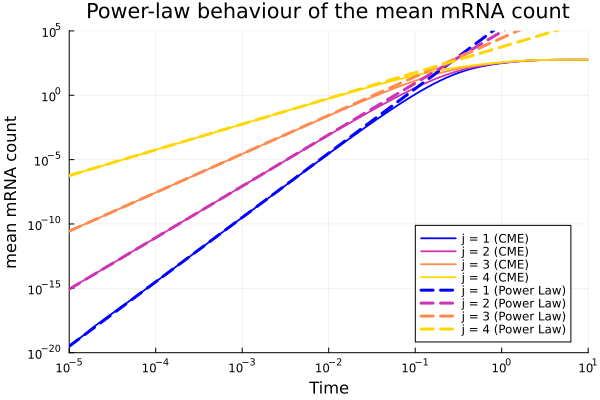

In [26]:
#Plot mean mRNA count (log-log plot)

#CME mean
plot(t_all, mean_t_5sm_j1, color=bblue, linewidth=1.8, label="j = 1 (CME)")
plot!(t_all, mean_t_5sm_j2, color=dpink, linewidth=1.8, label="j = 2 (CME)")
plot!(t_all, mean_t_5sm_j3, color=oorange, linewidth=1.8, label="j = 3 (CME)")
plot!(t_all, mean_t_5sm_j4, color=yyellow, linewidth=1.8, label="j = 4 (CME)")

#power law mean
plot!(t_all, powerlaw_mean_t_5sm_j1, color=bblue, linewidth=3, linestyle=:dash, label="j = 1 (Power Law)")
plot!(t_all, powerlaw_mean_t_5sm_j2, color=dpink, linewidth=3, linestyle=:dash, label="j = 2 (Power Law)")
plot!(t_all, powerlaw_mean_t_5sm_j3, color=oorange, linewidth=3, linestyle=:dash, label="j = 3 (Power Law)")
plot!(t_all, powerlaw_mean_t_5sm_j4, color=yyellow, linewidth=3, linestyle=:dash, label="j = 4 (Power Law)")

plot!(xscale=:log10, yscale=:log10, legend=:bottomright)

xlabel!("Time")
ylabel!("mean mRNA count")
title!("Power-law behaviour of the mean mRNA count")

xlims!(10^-5, 10^1)
ylims!(10^-20, 10^5)

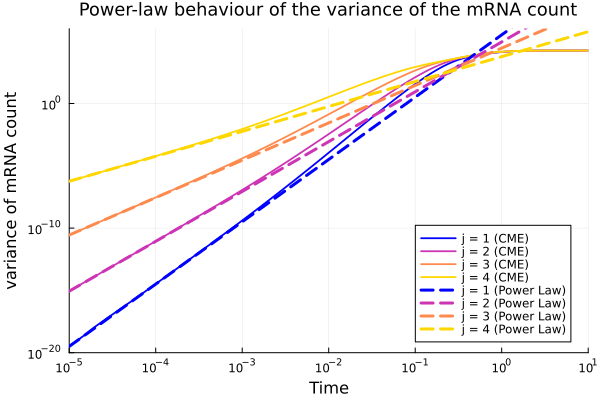

In [37]:
#Plot variance of the mRNA count (log-log plot)

#CME variance
plot(t_all, variance_t_5sm_j1, color=bblue, linewidth=1.8, label="j = 1 (CME)")
plot!(t_all, variance_t_5sm_j2, color=dpink, linewidth=1.8, label="j = 2 (CME)")
plot!(t_all, variance_t_5sm_j3, color=oorange, linewidth=1.8, label="j = 3 (CME)")
plot!(t_all, variance_t_5sm_j4, color=yyellow, linewidth=1.8, label="j = 4 (CME)")

#power law variance
plot!(t_all, powerlaw_variance_t_5sm_j1, color=bblue, linewidth=3, linestyle=:dash, label="j = 1 (Power Law)")
plot!(t_all, powerlaw_variance_t_5sm_j2, color=dpink, linewidth=3, linestyle=:dash, label="j = 2 (Power Law)")
plot!(t_all, powerlaw_variance_t_5sm_j3, color=oorange, linewidth=3, linestyle=:dash, label="j = 3 (Power Law)")
plot!(t_all, powerlaw_variance_t_5sm_j4, color=yyellow, linewidth=3, linestyle=:dash, label="j = 4 (Power Law)")

plot!(xscale=:log10, yscale=:log10, legend=:bottomright)

xlabel!("Time")
ylabel!("variance of mRNA count")
title!("Power-law behaviour of the variance of the mRNA count", titlefontsize=:12)

xlims!(10^-5, 10^1)
ylims!(10^-20, 10^6)

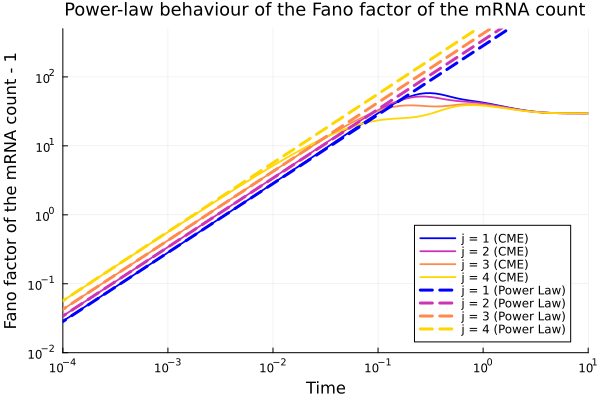

In [55]:
#Plot Fano factor of the mRNA count (log-log plot)

#CME FF
plot(t_all, FF_t_5sm_j1.-1, color=bblue, linewidth=1.8, label="j = 1 (CME)")
plot!(t_all, FF_t_5sm_j2.-1, color=dpink, linewidth=1.8, label="j = 2 (CME)")
plot!(t_all, FF_t_5sm_j3.-1, color=oorange, linewidth=1.8, label="j = 3 (CME)")
plot!(t_all, FF_t_5sm_j4.-1, color=yyellow, linewidth=1.8, label="j = 4 (CME)")

#power law FF
plot!(t_all, powerlaw_FF_t_5sm_j1.-1, color=bblue, linewidth=3, linestyle=:dash, label="j = 1 (Power Law)")
plot!(t_all, powerlaw_FF_t_5sm_j2.-1, color=dpink, linewidth=3, linestyle=:dash, label="j = 2 (Power Law)")
plot!(t_all, powerlaw_FF_t_5sm_j3.-1, color=oorange, linewidth=3, linestyle=:dash, label="j = 3 (Power Law)")
plot!(t_all, powerlaw_FF_t_5sm_j4.-1, color=yyellow, linewidth=3, linestyle=:dash, label="j = 4 (Power Law)")

plot!(xscale=:log10, yscale=:log10, legend=:bottomright)

xlabel!("Time")
ylabel!("Fano factor of the mRNA count - 1")
title!("Power-law behaviour of the Fano factor of the mRNA count", titlefontsize=:12)

xlims!(10^-4, 10^1)
ylims!(10^-2, 5*10^2)